In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
df= pd.read_csv("perrin-freres-monthly-champagne-.csv")
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [9]:
df.rename(columns={"Perrin Freres monthly champagne sales millions ?64-?72":"Sales"},inplace=True)
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [10]:
df.shape

(107, 2)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   106 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.8+ KB


In [12]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [13]:
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [26]:
df[df["Sales"].isna()]

,Month,Sales
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [30]:
df.iloc[106,:]

Month    Perrin Freres monthly champagne sales millions...
Sales                                                  NaN
Name: 106, dtype: object

In [33]:
df.dropna(axis=0,inplace=True)

In [34]:
df.isnull().sum()

Month    0
Sales    0
dtype: int64

In [35]:
df["Month"]=pd.to_datetime(df["Month"])

In [40]:
df["Month"].dtype

dtype('<M8[ns]')

In [41]:
df.set_index("Month",inplace=True)

In [42]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


<Axes: xlabel='Month'>

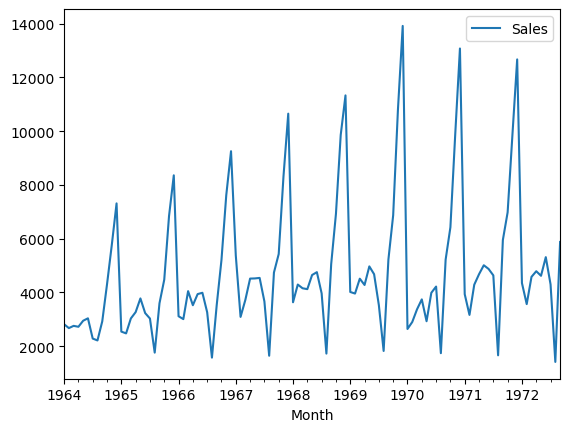

In [43]:
df.plot()

#### data is not stationary
#### seasonal trend

In [45]:
from statsmodels.tsa.stattools import adfuller

In [46]:
test_result=adfuller(df["Sales"])

In [48]:
test_result

(-1.8335930563276248,
 0.363915771660244,
 11,
 93,
 {'1%': -3.502704609582561,
  '5%': -2.8931578098779522,
  '10%': -2.583636712914788},
 1478.4633060594724)

In [73]:
#H0 -it is not stationary
#H1 - it is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels=['ADF Test statistics','P-value','Lags used','No of Observations used']
    for value, label in zip(result,labels):
        print(label + ' : '+ str(value))
    print("-"*20)
    if result[1] <= 0.05:
        print("Reject null hypotheses...Data is stationary")
    else:
        print("Reject alternate hypotheses(H1 - it is stationary)")
        print('Data is not stationary')
    

In [74]:
adfuller_test(df["Sales"])

ADF Test statistics : -1.8335930563276248
P-value : 0.363915771660244
Lags used : 11
No of Observations used : 93
--------------------
Reject alternate hypotheses(H1 - it is stationary)
Data is not stationary


In [78]:
df["sales first difference"]=df["Sales"]-df["Sales"].shift(1)
df["seasonal first difference"]=df["Sales"]-df["Sales"].shift(12)
df.head(15)

,Sales,sales first difference,seasonal first difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [77]:
adfuller_test(df["sales first difference"].dropna())

ADF Test statistics : -7.189896448051015
P-value : 2.5196204473868427e-10
Lags used : 11
No of Observations used : 92
--------------------
Reject null hypotheses...Data is stationary


In [79]:
adfuller_test(df["seasonal first difference"].dropna())

ADF Test statistics : -7.626619157213163
P-value : 2.060579696813685e-11
Lags used : 0
No of Observations used : 92
--------------------
Reject null hypotheses...Data is stationary


<Axes: xlabel='Month'>

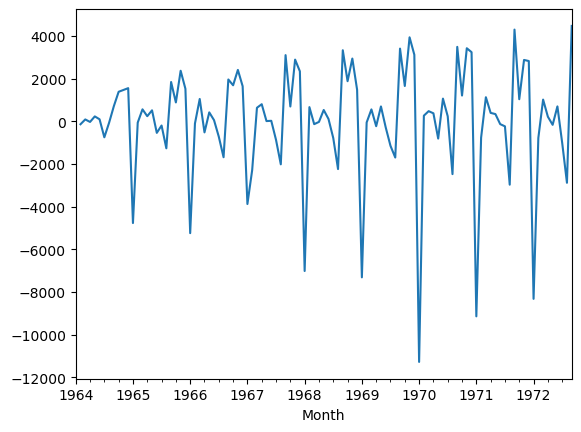

In [82]:
df['sales first difference'].plot()

<Axes: xlabel='Month'>

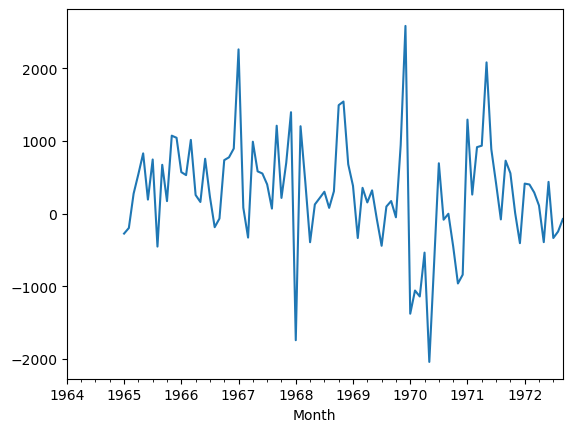

In [81]:
df['seasonal first difference'].plot()

## Seasonal first difference looks more stationary

In [84]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

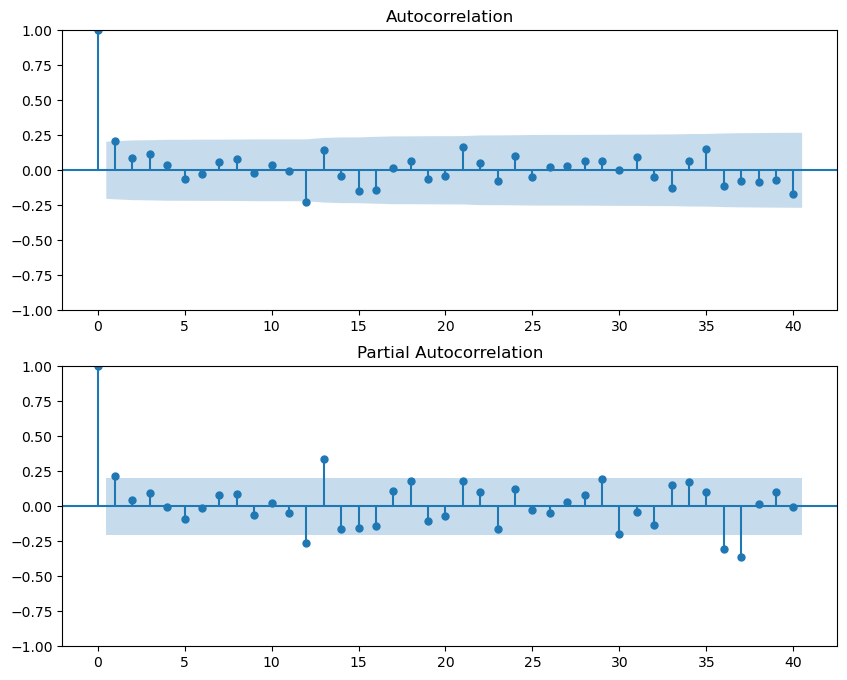

In [93]:
fig=plt.figure(figsize=(10,8))
ax1=fig.add_subplot(211)
fig=plot_acf(df['seasonal first difference'].iloc[13:],lags=40,ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df['seasonal first difference'].iloc[13:],lags=40,ax=ax2)


## ARIMA hyperparameters
## p=1,d=1,q=1

In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [98]:
model=SARIMAX(df["Sales"],order=(1,1,1),seasonal_order=(1,1,1,12))
result=model.fit()

C:\Users\JASON\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JASON\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='Month'>

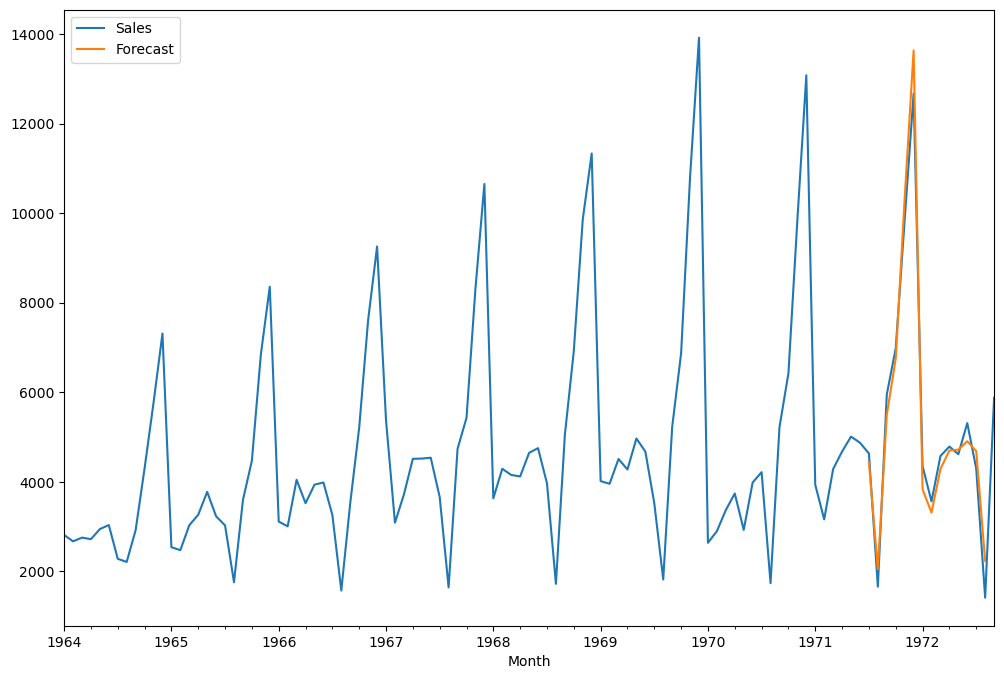

In [114]:
df["Forecst"]=result.predict(start=90,end=103,dynamic=True)
df[['Sales','Forecast']].plot(figsize=(12,8))

## Prediction for future months

In [103]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [104]:
print(future_dates)

[Timestamp('1972-09-01 00:00:00'), Timestamp('1972-10-01 00:00:00'), Timestamp('1972-11-01 00:00:00'), Timestamp('1972-12-01 00:00:00'), Timestamp('1973-01-01 00:00:00'), Timestamp('1973-02-01 00:00:00'), Timestamp('1973-03-01 00:00:00'), Timestamp('1973-04-01 00:00:00'), Timestamp('1973-05-01 00:00:00'), Timestamp('1973-06-01 00:00:00'), Timestamp('1973-07-01 00:00:00'), Timestamp('1973-08-01 00:00:00'), Timestamp('1973-09-01 00:00:00'), Timestamp('1973-10-01 00:00:00'), Timestamp('1973-11-01 00:00:00'), Timestamp('1973-12-01 00:00:00'), Timestamp('1974-01-01 00:00:00'), Timestamp('1974-02-01 00:00:00'), Timestamp('1974-03-01 00:00:00'), Timestamp('1974-04-01 00:00:00'), Timestamp('1974-05-01 00:00:00'), Timestamp('1974-06-01 00:00:00'), Timestamp('1974-07-01 00:00:00'), Timestamp('1974-08-01 00:00:00')]


In [105]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [106]:
future_datest_df.head()

,Sales,sales first difference,seasonal first difference,Forecast,Forecst
1972-10-01,NaN,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN,NaN


In [107]:
future_df=pd.concat([df,future_datest_df])

<Axes: >

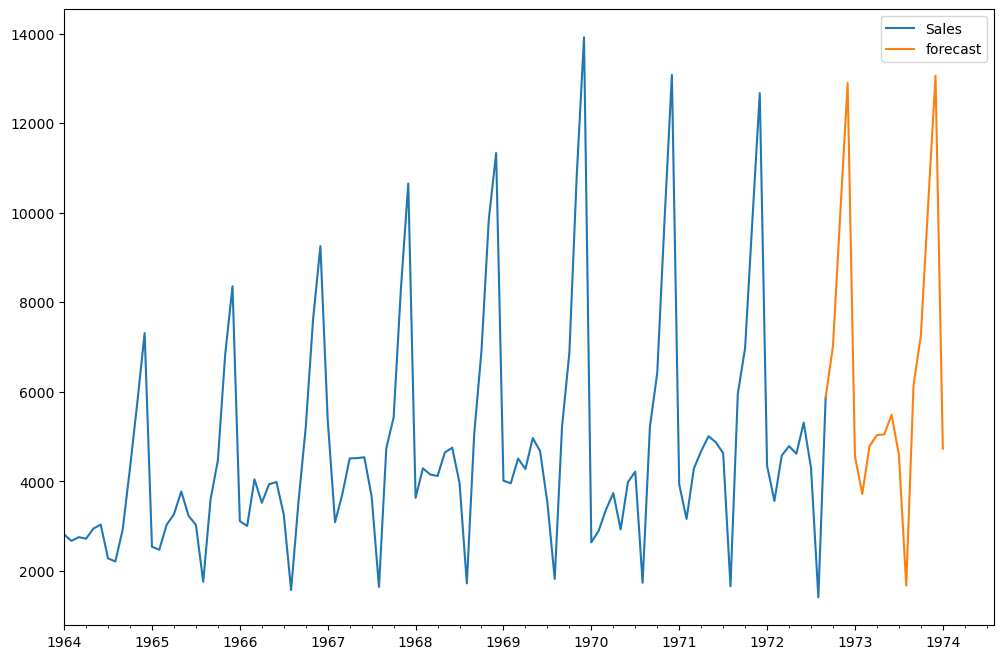

In [113]:
future_df['forecast'] = result.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 